<a href="https://colab.research.google.com/github/jeff0994/LaboratorioAvanzadoII/blob/master/LaboratorioAvanzadoII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Universidad de Costa Rica**
## **Facultad de Ciencias**
##**Escuela de Física**





# Proyecto Laboratorio Avanzado


### Hoja de prueba:Empleo de métodos supervizados de Machine Learning para correción de errores cuánticos.

### Fecha 8/04/20202

#### **Profesor** Ph.D Mauricio Gutierrez

#### Autor David ¿Cual es tu apellido? ....

#### **Estudiante**  Yefry López


### Estructura.

* Prueba con Regresión Lógistica
* Prueba con Random Forest
* Prueba con Red Neuronal Recurrente LSTM



 #### Importación de paquetes necesarios

In [0]:
import json
import os
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#### Montar el Google Drive en el Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#### Cargar datos al Colab

In [0]:
#Para Test
path_to_json = 'gdrive/My Drive/Datos/' #path
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

In [0]:
#Comprobar la cantidad de archivos cargados al Colab
json_files 

['0.json',
 '1.json',
 '2.json',
 '3.json',
 '4.json',
 '5.json',
 '6.json',
 '7.json',
 '8.json',
 '9.json',
 '10.json',
 '11.json',
 '13.json',
 '14.json',
 '15.json',
 '16.json',
 '17.json',
 '12.json',
 '18.json',
 '19.json']

In [0]:
json_text.keys() #Variable no existe Saber si los keys estaban en json #Utilidad Nula

NameError: ignored

#### Prepocesamiento de Datos

In [0]:
""" 
Crea 4 listas de Python x_correc , x_stab , z_correc y z_stab
Las listas se irán llenando a partir de los archivos json cargados

x_correc resulta en una lista de longitud 9 de lista que contienen los caracteres 'I' y 'X'
z_correc resulta en una lista de longitud 9 de lista que contienen los caracteres 'I' y 'Z'

Cada caracter simboliza un qubit (total 9 qubits), donde aparezca X y Z implica que el simulador interpreta que dicho
qubit hay que hacerle la correción en X o Z

Se usa simulador con código de superficie
8 estabilizadores, 4 en X y 4 en Z
Para cada estabilizador se mide 3 veces

x_stab y z_stab da como resultado una lista de shape 20X50000

Formato  z_stab[0][0] = [[Medición1],[Medición2],[Medición3]]
         z_stab[0][0] = [[Estabilizador1,Estabilizador2,Estabilizador3],[Estabilizador1,Estabilizador2,Estabilizador3],[Estabilizador1,Estabilizador2,Estabilizador3]]


""" 

x_correc = []
x_stab = []
z_correc = []
z_stab = []
final_errors = []
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        x_correc.append(json_text['X_corrections'])
        x_stab.append(json_text['X_stab_outcomes'])
        z_correc.append(json_text['Z_corrections'])
        z_stab.append(json_text['Z_stab_outcomes'])
        final_errors.append(json_text['failings_total_NN'])

In [0]:
print("Lenth of z[0]",len(z_stab[0]))
print("Se imprimen las tres corridas z[0][0] ",z_stab[0][0])
print("Se imprime la corrida 1 de z[0][0]" ,z_stab[0][0][0])

Lenth of z[0] 50000
Se imprimen las tres corridas z[0][0]  [[0, 1, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]]
Se imprime la corrida 1 de z[0][0] [0, 1, 0, 0]


#### Interpretación 

Para la primer corrida en z[0][0], hay error en el segundo estabilizador <br>
Para la segunda corrida en z[0][1] se detectan errores en los 4 estabilizadores <br>
Para la tercer corrida z[0][2] se detectan error en el estabilizador 3 y 4  <br>

In [0]:
# Hay corridas donde las mediciones son iguales, por tanto el simulador las obvia
#Acá se rellena los que tienen solo dos mediciones iguales x
for i in range(0,len(x_stab)):
    for j in range(0,len(x_stab[i])):
        if len(x_stab[i][j]) != 3:
           x_stab[i][j].append(x_stab[i][j][0])

In [0]:
#rMismo caso que anterior celda
for i in range(0,len(z_stab)):
    for j in range(0,len(z_stab[i])):
        if len(z_stab[i][j]) != 3:
           z_stab[i][j].append(z_stab[i][j][0])

In [0]:
# Se agrupan los datos de los estabilizadores Z?
dataz_stab =[]
for i in range(0,len(z_stab)):
    for j in range(0,len(z_stab[i])):
        for k in range(0,len(z_stab[i][j])):
            for l in range(0,len(z_stab[i][j][k])):
                dataz_stab.append(z_stab[i][j][k][l])

In [0]:
#Se agrupan los datos de los estabilizadores X?
datax_stab =[]
for i in range(0,len(x_stab)):
    for j in range(0,len(x_stab[i])):
        for k in range(0,len(x_stab[i][j])):
            for l in range(0,len(x_stab[i][j][k])):
                datax_stab.append(x_stab[i][j][k][l])

In [0]:
numeric = [] #Tranforma True and Falsa de 1 a 0 Lo saca de la lista de la lista
for i in range(0,len(final_errors)):
    for j in range(0,len(final_errors[i])):
        numeric.append(final_errors[i][j])
numeric = np.array(numeric).astype(int)

In [0]:
numeric

array([1, 1, 0, ..., 1, 0, 0])

In [0]:
datax_stab = np.array(datax_stab).reshape((len(json_files)*len(json_text['X_corrections']),12))
dataz_stab = np.array(dataz_stab).reshape((len(json_files)*len(json_text['X_corrections']),12))

indices = []
for index, (vectx, vectz) in enumerate(zip(datax_stab,dataz_stab)):
        if max(vectx)==0 & max(vectz)==0:
            indices.append(index)
delete = indices#[:corte]
datax_stab=np.delete(datax_stab,delete,axis=0)
dataz_stab=np.delete(dataz_stab,delete,axis=0)
numeric = np.delete(numeric,delete,axis=0)
datax3 = np.array(datax_stab).reshape(len(datax_stab)*3,4)
dataz3 = np.array(dataz_stab).reshape(len(datax_stab)*3,4)
numeric3 = []
for i in range(0,len(datax_stab)):
    for j in range(0,3):
        numeric3.append(numeric[i])
numeric3 = np.array(numeric3)
data3_stab = np.concatenate((datax3,dataz3),axis = 1)
data3 = np.concatenate((data3_stab,numeric3.reshape(len(datax_stab)*3,1)),axis=1)

In [0]:
#Caso trivial, alta probabilidad de que no hubo error
indices = []
for index, (vectx, vectz) in enumerate(zip(datax_stab,dataz_stab)):
        if max(vectx)==0 & max(vectz)==0:
            indices.append(index)

In [0]:
delete = indices[:]#[:corte]

In [0]:
corte =len(datax_stab)-len(indices)

In [0]:
datax_stab=np.delete(datax_stab,delete,axis=0)
dataz_stab=np.delete(dataz_stab,delete,axis=0)
numeric = np.delete(numeric,delete,axis=0)

In [0]:
datax3 = np.array(datax_stab).reshape(len(datax_stab)*3,4)
dataz3 = np.array(dataz_stab).reshape(len(datax_stab)*3,4)

In [0]:
numeric3 = []
for i in range(0,len(datax_stab)):
    for j in range(0,3):
        numeric3.append(numeric[i])
numeric3 = np.array(numeric3)

In [0]:
data3_stab = np.concatenate((datax3,dataz3),axis = 1)
data3 = np.concatenate((data3_stab,numeric3.reshape(len(datax_stab)*3,1)),axis=1)

In [0]:
data3.shape #conjunto de las tres rondas

(2918553, 9)

data3_stap.shape


In [0]:
np.savetxt('training_p01.csv',data3,delimiter=",")

#### Repaso de Métricas
https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall

## Precisión
¿Qué proporción de identificaciones positivas fue correcta? <br>

$$ \frac{TP}{TP+FP}$$

## Exhautividad o Recall (recuperación)
¿Qué proporción de positivos reales se identificó correctamente?

$$ \frac{TP}{TP+FN}$$



### Regresión Logistica

Input x:data3_stab <br>
Input y: numeric3 <br>



In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

In [0]:
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(data3_stab, numeric3, test_size=0.20, random_state=0)

In [0]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [0]:
model.fit(log_X_train,log_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
log_y_hat = model.predict(log_X_test)

In [0]:
model.score(log_X_test,log_y_test)

0.5464159489884549

In [0]:
accuracy_score(log_y_test, log_y_hat)

0.5464159489884549

In [0]:
recall_score(log_y_test, log_y_hat)

0.01372342314769683

In [0]:
confusion_matrix(y_test,y_hat)

array([[315317,   3737],
       [261025,   3632]])

El modelo predice 315317 True positives <br>
El modelo predice 3632 True Negative <br>
El modelo predice 3737 Falsos Negativos <br>
El modelo predice 261025 Falsos positivos <br>

#### Reporte

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.55      0.99      0.70    319054
           1       0.49      0.01      0.03    264657

    accuracy                           0.55    583711
   macro avg       0.52      0.50      0.37    583711
weighted avg       0.52      0.55      0.40    583711



#### Logistica Manual


In [0]:
x_training_log = data3_stab[0:round(len(data3_stab)*0.8),]
y_training_log = numeric3[0:round(len(data3_stab)*0.8),]

x_test_log = data3_stab[round(len(data3_stab)*0.8):len(data3_stab),]

y_test_log = numeric3[round(len(data3_stab)*0.8):len(data3_stab),]

In [0]:
model = LogisticRegression(solver='liblinear', random_state=0)

model.fit(x_training_log,y_training_log)

y_predicho = model.predict(x_test_log)



In [0]:
model.score(x_test_log,y_test_log)

0.5451139348067794

In [0]:
confusion_matrix(y_test_log,y_predicho)

array([[314594,   3785],
       [261737,   3595]])

#### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

RF_X_train, RF_X_test, RF_y_train, RF_y_test = train_test_split(data3_stab, numeric3, test_size=0.20, random_state=0)

# Fit on training data
model.fit(RF_X_train, RF_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Actual class predictions
rf_predictions = model.predict(RF_X_test)
# Probabilities for each class
rf_probs = model.predict_proba(RF_X_test)[:,1]

In [0]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(RF_y_test, rf_probs)

In [0]:
# Make probability predictions
train_probs = model.predict_proba(RF_X_train)[:, 1]
probs = model.predict_proba(RF_X_test)[:, 1]

In [0]:
print(f'Train ROC AUC Score: {roc_auc_score(RF_y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(RF_y_test, probs)}')

Train ROC AUC Score: 0.5270806013519399
Test ROC AUC  Score: 0.5262437503276649


Métrica para RandomForest 
curva ROC (curva de característica operativa del recepto) 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

In [0]:
roc_value

0.5262437503276649

The final testing ROC AUC for the random forest was 0.5262 

The perfect value for ROC AUC value is 1.0

In [0]:
from sklearn.metrics import roc_curve

FPR, TPR, thresholds = roc_curve(RF_y_test, rf_probs, pos_label=None, sample_weight=None, drop_intermediate=True)

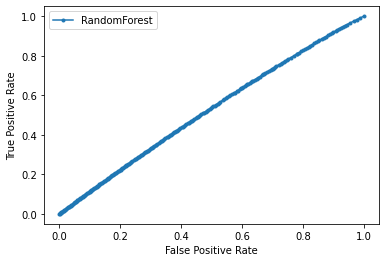

In [0]:
from matplotlib import pyplot

# plot the roc curve for the model
pyplot.plot(FPR, TPR, marker='.', label='RandomForest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [0]:
#ConfusionMatrix

confusion_matrix(RF_y_test,rf_predictions)

array([[317461,   1593],
       [263184,   1473]])

In [0]:
print(classification_report(RF_y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.55      1.00      0.71    319054
           1       0.48      0.01      0.01    264657

    accuracy                           0.55    583711
   macro avg       0.51      0.50      0.36    583711
weighted avg       0.52      0.55      0.39    583711



### Optimización Random Forest con CV Search

Basado en 
https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb



In [0]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier()

In [0]:
# Create the random search model
rf = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1)

In [0]:
# Fit 
rf.fit(RF_X_train, RF_y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 79.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
rf.best_params_

{'bootstrap': True,
 'max_depth': 13,
 'max_features': 0.7,
 'max_leaf_nodes': 49,
 'min_samples_split': 5,
 'n_estimators': 72}

In [0]:
#Modelo Optimiazado

best_model = rf.best_estimator_

In [0]:
train_rf_predictions = best_model.predict(RF_X_train)
train_rf_probs = best_model.predict_proba(RF_X_train)[:, 1]

rf_predictions = best_model.predict(RF_X_test)
rf_probs = best_model.predict_proba(RF_X_test)[:, 1]

In [0]:
%matplotlib inline

In [0]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(predictions, probs, train_predictions, train_probs,test_labels = RF_y_test ,train_labels= RF_y_train):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Baseline: 1.0 Test: 0.0 Train: 0.0
Precision Baseline: 0.45 Test: 0.0 Train: 0.0
Roc Baseline: 0.5 Test: 0.53 Train: 0.53


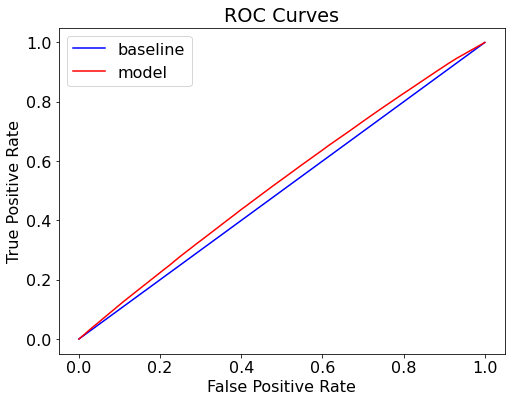

In [0]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [0]:
print(f'Train ROC AUC Score: {roc_auc_score(RF_y_train, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(RF_y_test, rf_probs)}')

Train ROC AUC Score: 0.5266665417829499
Test ROC AUC  Score: 0.5268531094405021


#### Red Neural Recurrente

In [0]:
def separar_secuencia(secuencia,pasos_tiempo):
    x, y = list(), list()
    for i in range(len(secuencia)):
        final_ix = i +pasos_tiempo
        if final_ix > len(secuencia)-1:
            break
        #juntamos la serie y resultado del siguiente paso
        seq_x, seq_y = secuencia[i:final_ix,:-1], secuencia[final_ix-1,-1]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [0]:
pasos_tiempo3 = 3
x3_0, y3_0 = separar_secuencia(data3,pasos_tiempo3)

In [0]:
x3_0

array([[[0, 1, 1, ..., 1, 0, 0],
        [1, 0, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 1, 1]],

       [[1, 0, 1, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 1, 1, ..., 1, 0, 1]],

       [[0, 0, 0, ..., 0, 1, 1],
        [0, 1, 1, ..., 1, 0, 1],
        [1, 1, 0, ..., 1, 1, 0]],

       ...,

       [[0, 1, 1, ..., 0, 1, 1],
        [0, 1, 0, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 0, 1]],

       [[0, 1, 0, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 0, 1],
        [1, 1, 0, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 0, 1],
        [1, 1, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 1, 0]]])

In [0]:
x3 = []
y3 = []
for index in range(0,len(x3_0)):
    if index==0:
        x3.append(x3_0[index])
    elif index%3 == 0:
        x3.append(x3_0[index])
for index in range(0,len(y3_0)):
    if index==0:
        y3.append(y3_0[index])
    elif index%3 == 0:
        y3.append(y3_0[index])
x3 = np.array(x3)
y3 = np.array(y3)

In [0]:
indices = np.arange(x3.shape[0])

In [0]:
np.random.shuffle(indices)

In [0]:
x3 = x3[indices]
y3 = y3[indices]

In [0]:
x_train3 = x3[0:round(len(x3)*0.8)]
y_train3 = y3[0:round(len(y3)*0.8)]
x_test3 = x3[round(len(x3)*0.8):len(x3)]
y_test3 = y3[round(len(y3)*0.8):len(y3)]

In [0]:
y_train3= keras.utils.to_categorical(y_train3,num_classes=2)
y_test3 = keras.utils.to_categorical(y_test3,num_classes=2)

In [0]:
n_stab3 = 8

In [0]:
model3 = Sequential()
model3.add(LSTM(128,
               activation = 'relu',
               return_sequences = True,
               input_shape = (pasos_tiempo3,n_stab3)))
model3.add(LSTM(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(64,activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(32,activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(16,activation = 'relu'))
model3.add(Dense(2, activation='softmax'))

In [0]:
model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
x_train3.shape

(778280, 3, 8)

In [0]:
model3.fit(x_train3, y_train3,batch_size=300, epochs=20,verbose=1)

Epoch 1/20
778280/778280 [==============================] - 117s 150us/step - loss: 0.6872 - accuracy: 0.5449
Epoch 2/20
778280/778280 [==============================] - 113s 146us/step - loss: 0.6862 - accuracy: 0.5448
Epoch 3/20
778280/778280 [==============================] - 113s 145us/step - loss: 0.6861 - accuracy: 0.5450
Epoch 4/20
778280/778280 [==============================] - 112s 143us/step - loss: 0.6859 - accuracy: 0.5450
Epoch 5/20
778280/778280 [==============================] - 111s 142us/step - loss: 0.6858 - accuracy: 0.5450
Epoch 6/20
778280/778280 [==============================] - 111s 142us/step - loss: 0.6858 - accuracy: 0.5448
Epoch 7/20
186000/778280 [======>.......................] - ETA: 1:25 - loss: 0.6857 - accuracy: 0.5463

KeyboardInterrupt: ignored

In [0]:
model3.save('modelo.h5')

In [0]:
score3 = model3.evaluate(x_test3, y_test3, batch_size=256)
score3

324000/324000 [==============================] - 9s 29us/step


[0.5007690983171816, 0.7523765431981028]

In [0]:
from keras.models import load_model

In [0]:
model3 = load_model('modelo.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
texto = """x_correc_02e = []
x_stab_02e = []
z_correc_02e = []
z_stab_02e = []
final_errors_02e = []
with open(path_to_json+'0_2.json') as json_file:
    json_text = json.load(json_file)
x_correc_02e.append(json_text['X_corrections'])
x_stab_02e.append(json_text['X_stab_outcomes'])
z_correc_02e.append(json_text['Z_corrections'])
z_stab_02e.append(json_text['Z_stab_outcomes'])
final_errors_02e.append(json_text['failings_total_NN'])
for i in range(0,len(x_stab_02e)):
    for j in range(0,len(x_stab_02e[i])):
        if len(x_stab_02e[i][j]) != 3:
           x_stab_02e[i][j].append(x_stab_02e[i][j][0])
#relleno los que tienen solo dos mediciones iguales z
for i in range(0,len(z_stab_02e)):
    for j in range(0,len(z_stab_02e[i])):
        if len(z_stab_02e[i][j]) != 3:
           z_stab_02e[i][j].append(z_stab_02e[i][j][0])
dataz_stab_02e =[]
for i in range(0,len(z_stab_02e)):
    for j in range(0,len(z_stab_02e[i])):
        for k in range(0,len(z_stab_02e[i][j])):
            for l in range(0,len(z_stab_02e[i][j][k])):
                dataz_stab_02e.append(z_stab_02e[i][j][k][l])
datax_stab_02e =[]
for i in range(0,len(x_stab_02e)):
    for j in range(0,len(x_stab_02e[i])):
        for k in range(0,len(x_stab_02e[i][j])):
            for l in range(0,len(x_stab_02e[i][j][k])):
                datax_stab_02e.append(x_stab_02e[i][j][k][l])
datax_stab_02e = np.array(datax_stab_02e).reshape((30000,12))
dataz_stab_02e = np.array(dataz_stab_02e).reshape((30000,12))
numeric_02e = []
for i in range(0,len(final_errors_02e[0])):
    for j in range(0,3):
        numeric_02e.append(final_errors_02e[0][i])
numeric_02e = np.array(numeric_02e).astype(int)
indices = []
for index, (vectx, vectz) in enumerate(zip(datax_stab_02e,dataz_stab_02e)):
        if max(vectx)==0 & max(vectz)==0:
            indices.append(index)
delete_02e = indices#[:corte]
datax_stab_02e=np.delete(datax_stab_02e,delete_02e,axis=0)
dataz_stab_02e=np.delete(dataz_stab_02e,delete_02e,axis=0)
numeric_02e = np.delete(numeric_02e,delete_02e,axis=0)
datax3 = np.array(datax_stab_02e).reshape(len(datax_stab_02e)*3,4)
dataz3 = np.array(dataz_stab_02e).reshape(len(datax_stab_02e)*3,4)
numeric3 = []
for i in range(0,len(datax_stab_02e)):
    for j in range(0,3):
        numeric3.append(numeric_02e[i])
numeric3 = np.array(numeric3)
data3_stab = np.concatenate((datax3,dataz3),axis = 1)
data3 = np.concatenate((data3_stab,numeric3.reshape(len(datax_stab_02e)*3,1)),axis=1)
pasos_tiempo3 = 3
x3_0, y3_0 = separar_secuencia(data3,pasos_tiempo3)
x3 = []
y3 = []
for index in range(0,len(x3_0)):
    if index==0:
        x3.append(x3_0[index])
    elif index%3 == 0:
        x3.append(x3_0[index])
for index in range(0,len(y3_0)):
    if index==0:
        y3.append(y3_0[index])
    elif index%3 == 0:
        y3.append(y3_0[index])
x3 = np.array(x3)
x3=x3[round(len(x3)*0.8):len(x3)]
y3 = np.array(y3)
y3=y3[round(len(y3)*0.8):len(y3)]
y3= keras.utils.to_categorical(y3,num_classes=2)
acc_02e = model3.evaluate(x3, y3, batch_size=256)[1]
delete_02e = len(delete_02e)
acc_02e"""

In [0]:
files = []
for file in json_files:
    files.append(file.replace('.json',''))

In [0]:
numbers = []
for n in files:
    numbers.append(n.replace('_',''))

In [0]:
for i,j in zip(files,numbers):
    print(i,j)
    t1 = texto.replace('0_2',i)
    string = j+'e'
    t2 = t1.replace('02e',string)
    exec(t2)

0_1 01
2055/2055 [==============================] - 1s 304us/step
0_2 02
3317/3317 [==============================] - 0s 28us/step
0_3 03
4144/4144 [==============================] - 0s 26us/step
0_4 04
4674/4674 [==============================] - 0s 27us/step
0_5 05
5065/5065 [==============================] - 0s 28us/step
0_6 06
5296/5296 [==============================] - 0s 24us/step
0_7 07
5482/5482 [==============================] - 0s 26us/step
0_8 08
5579/5579 [==============================] - 0s 31us/step
0_9 09
5681/5681 [==============================] - 0s 27us/step
1_0 10
2003/2003 [==============================] - 0s 31us/step
1_1 11
3319/3319 [==============================] - 0s 33us/step
1_2 12
4171/4171 [==============================] - 0s 26us/step
1_3 13
4720/4720 [==============================] - 0s 26us/step
1_4 14
5081/5081 [==============================] - 0s 28us/step
1_5 15
5317/5317 [==============================] - 0s 26us/step
1_6 16
5476/5476 [======

In [0]:
acc = np.array([acc_01e,acc_02e,acc_03e,acc_04e,acc_05e,acc_06e,acc_07e,acc_08e,acc_09e,acc_10e,acc_11e,acc_12e,acc_13e,acc_14e,acc_15e,acc_16e,acc_17e,acc_18e,acc_20e,acc_21e,acc_22e,acc_23e,acc_24e,acc_25e,acc_26e,acc_27e,acc_30e,acc_31e,acc_32e,acc_33e,acc_34e,acc_35e,acc_36e,acc_40e,acc_41e,acc_42e,acc_43e,acc_44e,acc_45e,acc_50e,acc_51e,acc_52e,acc_53e,acc_54e,acc_60e,acc_61e,acc_62e,acc_63e,acc_70e,acc_71e,acc_72e,acc_80e,acc_81e,acc_90e])

In [0]:
delete = np.array([delete_01e,delete_02e,delete_03e,delete_04e,delete_05e,delete_06e,delete_07e,delete_08e,delete_09e,delete_10e,delete_11e,delete_12e,delete_13e,delete_14e,delete_15e,delete_16e,delete_17e,delete_18e,delete_20e,delete_21e,delete_22e,delete_23e,delete_24e,delete_25e,delete_26e,delete_27e,delete_30e,delete_31e,delete_32e,delete_33e,delete_34e,delete_35e,delete_36e,delete_40e,delete_41e,delete_42e,delete_43e,delete_44e,delete_45e,delete_50e,delete_51e,delete_52e,delete_53e,delete_54e,delete_60e,delete_61e,delete_62e,delete_63e,delete_70e,delete_71e,delete_72e,delete_80e,delete_81e,delete_90e])

In [0]:
delete

array([19724, 13413,  9280,  6630,  4676,  3518,  2587,  2102,  1594,
       19986, 13406,  9146,  6401,  4596,  3416,  2620,  1896,  1565,
       13038,  8982,  6275,  4443,  3298,  2422,  1862,  1492,  8584,
        6070,  4298,  3110,  2385,  1822,  1414,  5762,  4210,  3061,
        2337,  1703,  1389,  3913,  2940,  2089,  1622,  1293,  2699,
        2020,  1590,  1184,  1908,  1421,  1120,  1319,  1127,  1006])

In [0]:
p = ['acc_01e','acc_02e','acc_03e','acc_04e','acc_05e','acc_06e','acc_07e','acc_08e','acc_09e','acc_10e','acc_11e','acc_12e','acc_13e','acc_14e','acc_15e','acc_16e','acc_17e','acc_18e','acc_20e','acc_21e','acc_22e','acc_23e','acc_24e','acc_25e','acc_26e','acc_27e','acc_30e','acc_31e','acc_32e','acc_33e','acc_34e','acc_35e','acc_36e','acc_40e','acc_41e','acc_42e','acc_43e','acc_44e','acc_45e','acc_50e','acc_51e','acc_52e','acc_53e','acc_54e','acc_60e','acc_61e','acc_62e','acc_63e','acc_70e','acc_71e','acc_72e','acc_80e','acc_81e','acc_90e']
#strings = []
"""for x in p:
    strings.append(str(x))
strings = np.array(strings)"""

'for x in p:\n    strings.append(str(x))\nstrings = np.array(strings)'

In [0]:
peso_cero = ['delete_01e','delete_02e','delete_03e','delete_04e','delete_05e','delete_06e','delete_07e','delete_08e','delete_09e','delete_10e','delete_11e','delete_12e','delete_13e','delete_14e','delete_15e','delete_16e','delete_17e','delete_18e','delete_20e','delete_21e','delete_22e','delete_23e','delete_24e','delete_25e','delete_26e','delete_27e','delete_30e','delete_31e','delete_32e','delete_33e','delete_34e','delete_35e','delete_36e','delete_40e','delete_41e','delete_42e','delete_43e','delete_44e','delete_45e','delete_50e','delete_51e','delete_52e','delete_53e','delete_54e','delete_60e','delete_61e','delete_62e','delete_63e','delete_70e','delete_71e','delete_72e','delete_80e','delete_81e','delete_90e']

In [0]:
fail = 1-acc

In [0]:
output_filename = 'summary_nn_p01.json'
output_dict = {}
for i in range(len(acc)):
    output_dict[str((int(numbers[i][0]),int(numbers[i][1])))] = fail[i]
output_json_file = open(output_filename, 'w')
json.dump(output_dict, output_json_file)
output_json_file.close()

In [0]:
p_cero = []
for name, number in zip(peso_cero,delete):
    p_cero.append([name,number])

In [0]:
final = []
for name, number in zip(p,fail):
    final.append([name,number])

In [0]:
with open("results_30mil.txt", 'w') as output:
    for row in final:
        output.write(str(row) + '\n')

In [0]:
with open("peso_cero.txt", 'w') as output:
    for row in p_cero:
        output.write(str(row) + '\n')